# Desicion Tree Practice

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.externals.six import StringIO   
from sklearn.tree import export_graphviz
import pydotplus

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
np.random.seed(42)

## 1. Question 

### 判斷這個人是否要當兵（常備役）

<img src="https://imgur.dcard.tw/MLB3IGs.jpg" width=500>



根據中華民國憲法第二十條
>「人民有依法律服兵役之義務」。

兵役法第一條
>「中華民國男子依法皆有服兵役之義務」。

兵役法規定
> 男子年滿十八歲之翌年一月一日起役，至屆滿四十五歲之年十二月三十一日除役時止

基本上，所有18歲以上的的 “男生” 都需要當兵（常備役）。

但是也有一些例外，根據[身高體重體位區分標準表](http://servap3.docms.gov.taipei/pdf/102121101.pdf)，BMI不符合標準的可以不用當常備役兵。

> 常備役體位
> 17≦BMI≦31

扁平足也不屬於常備役體位

## 2. Attributes

1. 性別（Sex）：男生（1），女生（0）
2. 年齡（Age）：<100 的 Integer，代表年齡
3. BMI指數（BMI）：< 100 的 Float，代表BMI
4. 扁平足（flat feet）：有扁平足（1)，無扁平足（0）
5. 是否需要當兵（Target）：需要當兵（1），不需要當兵（0）

## 3. Designed Rules

以下四個條件同時成立

1. 性別 = 1 （男生）
2. 年齡 >= 18
3. 17 <= BMI <= 31
4. 扁平足 = 0（無扁平足）


假定 Decision Tree：

<img src='thumbs/my_dt.png' width=400 align=left>

## 4. Generate Data

* 性別
    
    爲了避免unbalanced data，產生70%男生和30%女生
    

* 年齡
    
    在14~22歲之間以uniform distribution生成
    
    
* BMI
    
    根據[衛服部統計資料](https://www.mohw.gov.tw/dl-13424-64eb6290-6a45-4a5d-aa6a-77b5c3deb327.html)

    > 臺灣男性（19~44歲）BMI：平均值 24.5，標準誤 0.3，樣本數426

    > 臺灣女性（19~44歲）BMI：平均值 23.0，標準誤 0.3，樣本數510
    
    用以下公式轉換：
    
    $$標準差（SD） =  標準誤 × \sqrt{樣本數}$$
    
    得出結果：
    
    > 男性標準差：6.19
    
    > 女性標準差：6.77
   
    
* 扁平足
    
    根據[wiki扁平足](https://zh.wikipedia.org/wiki/%E6%89%81%E5%B9%B3%E8%B6%B3)
    
    > 有15~30%的世界人口有一定程度的扁平足
    
    因爲找不到臺灣的統計資料，假設 **20%** 的臺灣人有扁平足
    
    
* 是否需要當兵
    
    如果以下四個條件都成立，則判斷需要當兵
    
    
    1. 性別 = 1 （男生）
    2. 年齡 >= 18
    3. 17 <= BMI <= 31
    4. 扁平足 = 0（無扁平足）


In [2]:
data_size = 10000
male_size = round(data_size * 0.7)
female_size = data_size - male_size
# Generate sex, 70% male, 30% female
male = np.ones(round(male_size))
female = np.zeros(round(female_size))
sex = np.concatenate((male, female))

# Generate age, from 14 to 22, uniform
age = np.random.randint(14, 22 + 1, data_size)

# Generate BMI
male_BMI = np.random.normal(24.5, 6.19, round(male_size))
female_BMI = np.random.normal(23.0, 6.77, round(female_size))

BMI = np.concatenate((male_BMI, female_BMI))

# Generate Flat Feet patient
flat_feet = np.random.choice([0, 1], data_size, p=[0.8, 0.2])

data = pd.DataFrame()
data['sex'] = sex
data['age'] = age
data['BMI'] = BMI.round(3)
data['flat_feet'] = flat_feet
data['target'] = np.zeros(data_size)

for index, row in data.iterrows():
    sex = row['sex']
    age = row['age']
    BMI = row['BMI']
    flat_feet = row['flat_feet']
    target = row['target']
    if sex == 1 and age >= 18 and BMI <= 31 and BMI >= 17 and flat_feet == 0:
        data.at[index,'target'] = 1
        
        
#data.to_csv('data.csv')

In [3]:
data.head()

,sex,age,BMI,flat_feet,target
0,1.0,20,19.547,0,1.0
1,1.0,17,22.690,0,0.0
2,1.0,21,34.502,0,0.0
3,1.0,18,21.015,0,1.0
4,1.0,20,23.474,1,0.0


#### 1. 性別（Sex）

70% 男生， 30% 女生

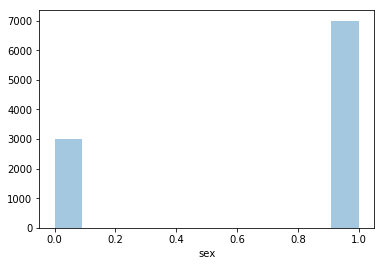

In [4]:
sns.distplot(data['sex'], kde=False)

#### 2. 年齡（Age）

14~24歲的 uniform distribution

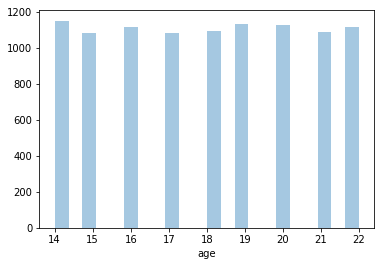

In [5]:
sns.distplot(data['age'], kde=False)

#### 3. BMI


根據[衛服部統計資料](https://www.mohw.gov.tw/dl-13424-64eb6290-6a45-4a5d-aa6a-77b5c3deb327.html)

> 臺灣男性（19~44歲）BMI：平均值 24.5，標準誤 0.3，樣本數426

> 臺灣女性（19~44歲）BMI：平均值 23.0，標準誤 0.3，樣本數510
    
用以下公式轉換：
    
$$標準差（SD） =  標準誤 × \sqrt{樣本數}$$
    
得出結果：
    
> 男性標準差：6.19
    
> 女性標準差：6.77

使用 Normal Distribution 生成


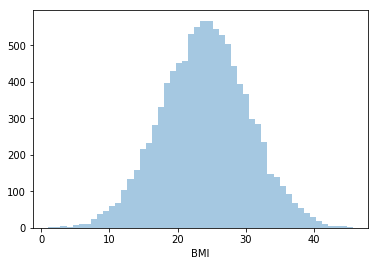

In [6]:
sns.distplot(data['BMI'], kde=False)

#### 4. 扁平足（Flat Feet）

20% 扁平足， 80% 非扁平足

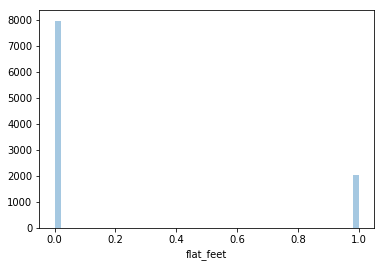

In [7]:
sns.distplot(data['flat_feet'], kde=False)

#### 5. Target

1:要當兵
0:不用當兵

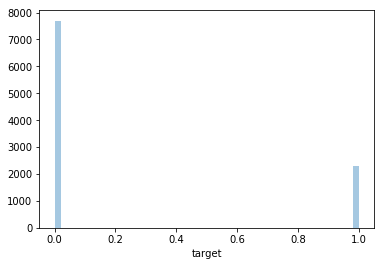

In [8]:
sns.distplot(data['target'], kde=False)

## 5. Construct Decision Tree

### 分割 Train、Test data

8000筆 Train data

2000筆 Test data

In [9]:
train = data[:8000]
test = data[8000:]

train_X = train[['sex', 'age', 'BMI', 'flat_feet']]
train_Y = train['target']
test_X = test[['sex', 'age', 'BMI', 'flat_feet']]
test_Y = test['target']

### 建立 Decison Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier

dtree=DecisionTreeClassifier()
dtree.fit(train_X,train_Y)

dot_data = StringIO()
export_graphviz(dtree, 
                out_file=dot_data,  
                filled=True, 
                feature_names=list(train_X),
                class_names=['NO','YES'],
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
res = graph.write_png("./thumbs/tree.png")
#assert(res == True)

### Decision Tree

<img src='thumbs/tree.png' width=350 align=left>

## 6. Compare with Rules

因爲產生的 Decision Tree 和原本的 Rule 互相吻合，test的準確度是100%

In [11]:
print('Accuracy on test data:')
print(dtree.score(test_X, test_Y))

Accuracy on test data:
1.0


## Report

### 1. 準確率

準確率：100% （2000筆測資）

因爲產生出的 Decision Tree 和設計的 Rules 一樣

### 2. Decision Tree

<img src='thumbs/my_dt.png' width=450 align=left> <img src='thumbs/tree.png' width=350 align=left>
<br>


分析：

* 層數：乍看之下總共有 4 個條件，應該有 5 層（如左邊的假想 Decision Tree），但是需要注意的是 CART Decision Tree 因爲使用 Gini Impurity，每一個條件都是 Binary 的分類，所以像 17 <= BMI <= 31 就會被拆成兩個條件 BMI >= 17（第三層） 和 BMI <= 31（第四層）。所以實際上產生的 Decision Tree總共會有 **6** 層


* 分類的順序：
    
    設計規則的時候分類的順序是 性別（Sex）-> 年齡（Age）-> 扁平足（flat feet）-> BMI
    
    實際的 Decision Tree 分類的順序是 年齡（Age）-> 扁平足（flat feet）-> BMI -> 性別（Sex）
    
    會產生這樣的情況是因爲：
        
        1. 在 Generate 性別的時候，採用的是 14~24 歲的 uniform distribution，所以理論上，>18 歲的人和 <18 歲的人應該要各佔 50%（實際上 4460(>18) 3540(<18))，所以對於 Decision Tree 來說，先用年齡當做分開的依據會讓 Gini Index最大，因此第一層就會使用年齡來進行區分
        
        2. 性別分類屬於第五層有些違反直覺，但是因爲在生成 Data 的時候考慮到避免 Unbalanced data 問題，所以男生有70%，女生有30%，所以在算 Gini Index 的時候，會比第一層的 Gini Index 小
        
* 葉節點（leaf node）：
    
    因爲產生的葉節點的 Gini Impurity 全部降爲0，代表這個 model 完全 fit 這些資料。這有可能是 over-fitting 的標志，但是因爲在 test dataset上準確率也是 100%，所以在這裏， Gini Impurity 降爲 0 是因爲 Decision Tree 和當初設計的 Rule 完全符合
    
* 最大深度（max depth):
    
    可以看到，在建立 Decision Tree 的時候並沒有設定 MaxDepth 的參數，因爲最後 Gini Impurity 都達到 0，所以樹不會繼續長下去

## Further Discussion

因爲 Data 沒有 Noise，所以 Decision Tree 在**不限制 maxdepth**的條件下，不會 over fit 並且可以做到 100% 的準確度

我們知道 Decision Tree 對 Noise 很敏感，所以接下來試着在 Data 裏面加一些 Noise，再觀察 Decision Tree 的情況

在 Dataset 裏面隨機抽取 N% 要當兵的人改成不用當兵

In [12]:
import random

def add_noise(noise_value):
    noise_data = data.copy()

    for index, row in noise_data.iterrows():
        if row['target'] == 1:
            if np.random.choice([0, 1], p=[1-noise_value, noise_value]):
                noise_data.at[index,'target'] = 0
                
    noise_train = noise_data[:8000]
    noise_test = noise_data[8000:]

    noise_train_X = noise_train[['sex', 'age', 'BMI', 'flat_feet']]
    noise_train_Y = noise_train['target']
    noise_test_X = noise_test[['sex', 'age', 'BMI', 'flat_feet']]
    noise_test_Y = noise_test['target']
    
    noise_dtree=DecisionTreeClassifier()
    noise_dtree.fit(noise_train_X,noise_train_Y)

    noise_dot_data = StringIO()
    export_graphviz(noise_dtree, 
                    out_file=noise_dot_data,  
                    filled=True, 
                    feature_names=list(noise_train_X),
                    class_names=['NO','YES'],
                    special_characters=True)

    noise_graph = pydotplus.graph_from_dot_data(noise_dot_data.getvalue())  

    return noise_graph

### 1. 隨機加入 0.1 % 的 Noise

In [13]:
_ = add_noise(0.001).write_png("./thumbs/noise_tree_1.png")

結果：

    可以看到 Decision Tree 上面的6層和原本的 Decision Tree 完全相同，但是爲了區分額外的 2 個sample（noise）而多出了 4 層

<img src='thumbs/noise_tree_1.png' width=350 align=left>

### 2. 隨機加入 0.5 % 的 Noise

In [14]:
_ = add_noise(0.005).write_png("./thumbs/noise_tree_5.png")

結果：

    可以看到 Decision Tree 上面的6層和原本的 Decision Tree 完全相同，但是爲了區分額外的 9 個sample（noise）而多出了 8 層

<img src='thumbs/noise_tree_5.png' width=700 align=left>

### Conclusion

Decision Tree 是對 Noise 很敏感的一種 Model，如果要除去對 Noise 的影響可以設定 max depth 參數來剪枝（取上 n 層）

# 僅此獻給所有還沒當兵的人
# 還好我退了！